In [1]:
import glob
import os
import sys

sys.path.insert(0, "..")

import pickle as pkl
import time
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch_geometric
from sklearn.metrics import auc, roc_curve
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataListLoader, DataLoader

import awkward as ak
import fastjet
import vector
vector.register_awkward()

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
# define the global base device
world_size = torch.cuda.device_count()
if world_size:
    device = torch.device("cuda:0")
    for i in range(world_size):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    device = "cpu"
    print("Device: CPU")

Device 0: NVIDIA GeForce RTX 3090


# JetClass Dataset
There are 10 classes of jets in the JetClass Dataset

In [3]:
label_dict = {}
labels = ['HToBB', 'HToCC', 'HToGG', 'HToWW2Q1L', 'HToWW4Q', 'TTBar', 'TTBarLep', 'WToQQ', 'ZToQQ', 'ZJetsToNuNu']
for i in range(len(labels)):
    label_dict[(i+1)%10] = labels[i]
label_dict

{1: 'HToBB',
 2: 'HToCC',
 3: 'HToGG',
 4: 'HToWW2Q1L',
 5: 'HToWW4Q',
 6: 'TTBar',
 7: 'TTBarLep',
 8: 'WToQQ',
 9: 'ZToQQ',
 0: 'ZJetsToNuNu'}

In [4]:
def load_data(dataset_path, flag):
    data_files = [f"{dataset_path}/train/data/{label}_000.pt" for label in labels]
        
    data = []
    for i, file in enumerate(data_files):
        data += torch.load(file)
        print(f"--- loaded file {file} from `{flag}` directory")
                
    return torch.stack(data)

In [5]:
all_jets = load_data("../../JetClass/processed", "train")

--- loaded file ../../JetClass/processed/train/data/HToBB_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/data/HToCC_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/data/HToGG_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/data/HToWW2Q1L_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/data/HToWW4Q_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/data/TTBar_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/data/TTBarLep_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/data/WToQQ_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/data/ZToQQ_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/data/ZJetsToNuNu_000.pt from `train` directory


In [6]:
all_jets.shape

torch.Size([1000000, 7, 128])

In [7]:
# onep_jets = torch.load("../../JetClass/processed/train_1%/data/data.pt")

In [8]:
# onep_jets.shape

In [9]:
def load_labels(dataset_path, flag):
    data_files = [f"{dataset_path}/train/label/labels_{label}_000.pt" for label in labels]
        
    data = []
    for i, file in enumerate(data_files):
        data += torch.load(file)
        print(f"--- loaded file {file} from `{flag}` directory")
                
    return torch.stack(data)

In [10]:
all_labels = load_labels("../../JetClass/processed", "train")

--- loaded file ../../JetClass/processed/train/label/labels_HToBB_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/label/labels_HToCC_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/label/labels_HToGG_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/label/labels_HToWW2Q1L_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/label/labels_HToWW4Q_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/label/labels_TTBar_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/label/labels_TTBarLep_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/label/labels_WToQQ_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/label/labels_ZToQQ_000.pt from `train` directory
--- loaded file ../../JetClass/processed/train/label/labels_ZJetsToNuNu_000.pt from `train` directory


In [11]:
all_labels.shape

torch.Size([1000000, 10])

## Convert one-hot encoded labels to class indices

In [12]:
all_labels = torch.argmax(all_labels, dim=1)
all_labels.shape

torch.Size([1000000])

In [13]:
all_labels

tensor([1, 1, 1,  ..., 0, 0, 0])

## Reduce the number of jets by a factor of 10

In [14]:
some_jets = torch.empty(torch.Size([100000, 7, 128]))
some_labels = torch.empty(torch.Size([100000]))

for i in tqdm(range(len(all_labels))):
    if i % 10 == 0:
        label = all_labels[i]
        jet = all_jets[i]
        
        some_jets[int(i / 10), :, :] = jet
        some_labels[int(i / 10)] = label

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [15]:
some_jets.shape

torch.Size([100000, 7, 128])

In [16]:
some_labels.shape

torch.Size([100000])

## Augmented jets

In [17]:
from src.models.jet_augs import *

In [18]:
# def augmentation(x, device):
#     """
#     Applies all the augmentations specified in the args
#     """
#     y = x.clone()
#     y = rotate_jets(y, device)
#     y = collinear_fill_jets(y, device)
#     y = collinear_fill_jets(y, device)
#     y = distort_jets(y, device, 0.1, 0.1)
#     y = translate_jets(y, device, width=1.0)
#     return y

In [19]:
from tqdm import tqdm

def augmentation(x, device):
    """
    Applies all the augmentations specified in the args
    """
    y = x.clone()

    transformations = [
        ("Rotating jets", lambda x, device: rotate_jets(x, device)),
        ("Collinear fill 1", lambda x, device: collinear_fill_jets(x, device)),
        ("Collinear fill 2", lambda x, device: collinear_fill_jets(x, device)),
        ("Distorting jets", lambda x, device: distort_jets(x, device, 0.1, 0.1)),
        ("Translating jets", lambda x, device: translate_jets(x, device, width=1.0))
    ]

    for desc, func in tqdm(transformations, desc="Augmenting", ncols=100):
        y = func(y, device)

    return y


In [20]:
some_jets = some_jets.to(device)
some_jets.device

device(type='cuda', index=0)

In [21]:
augmented_jets = augmentation(some_jets, device)

Augmenting: 100%|████████████████████████████████████████████████████| 5/5 [29:18<00:00, 351.75s/it]


In [22]:
augmented_jets.shape

torch.Size([100000, 7, 128])

# Data exploration

In [26]:
save_path = "../../JetClass/plots"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

0

In [68]:
def get_inv_xformation(feature):
    """
    The following standardization were applied to certain features when making the data files:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
    """
    if feature == "pt":
        return lambda x: x / 0.7 + 1.7
    elif feature == "E":
        return lambda x: x / 0.7 + 2.0
    elif feature == "pt/jet_pt":
        return lambda x: x / 0.7 - 4.7
    elif feature == "E/jet_E":
        return lambda x: x / 0.7 - 4.7
    elif feature == "deltaR":
        return lambda x: x / 4.0 + 0.2

### Multiplicity of original jets

In [30]:
multiplicity = {}
for label in labels:
    multiplicity[label] = []
    
for label, jet in zip(all_labels, all_jets):
    multiplicity[label_dict[label.item()]].append(int(torch.count_nonzero(jet) / 7))

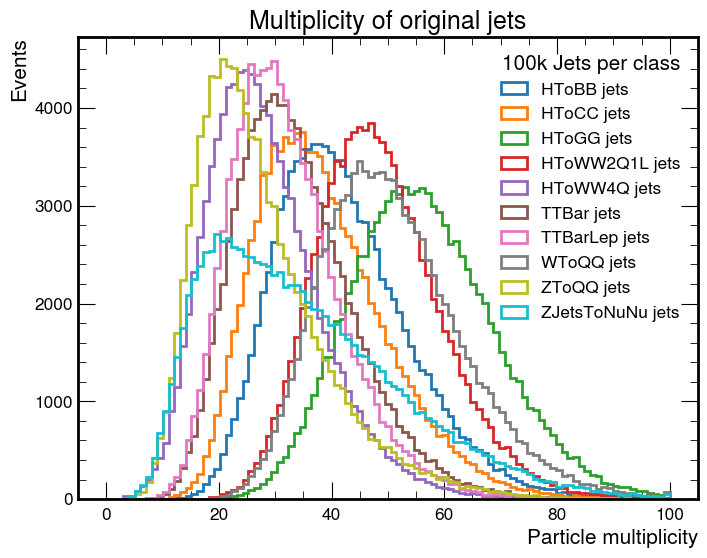

In [31]:
plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(8, 6))
for label in labels:
    plt.hist(multiplicity[label], bins=np.linspace(0,100,100), histtype="step", linewidth=2, label=f"{label} jets")

# ax.set_xlim(40,400)
# ax.set_ylim(0,0.4)
ax.legend(title="100k Jets per class")
ax.set_xlabel(r"Particle multiplicity");
ax.set_ylabel(r"Events");
plt.title("Multiplicity of original jets")
plt.savefig(f"{save_path}/multiplicity_orig", bbox_inches='tight', dpi=300)
plt.show()


### Multiplicity of augmented jets

In [32]:
multiplicity = {}
for label in labels:
    multiplicity[label] = []
    
for label, jet in zip(some_labels, augmented_jets):
    multiplicity[label_dict[label.item()]].append(int(torch.count_nonzero(jet) / 7))

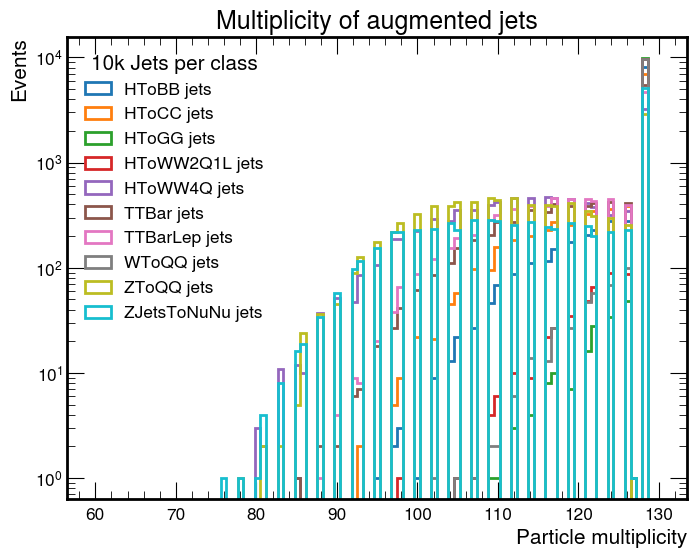

In [35]:
plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(8, 6))
for label in labels:
    plt.hist(multiplicity[label], bins=np.linspace(60,130,100), histtype="step", linewidth=2, label=f"{label} jets")

# ax.set_xlim(40,400)
# ax.set_ylim(0,0.4)
ax.legend(title="10k Jets per class")
ax.set_xlabel(r"Particle multiplicity");
ax.set_ylabel(r"Events");
ax.set_yscale('log');
plt.title("Multiplicity of augmented jets")
plt.savefig(f"{save_path}/multiplicity_augmented", bbox_inches='tight', dpi=300)
plt.show()


# Input Kinematic Features
The 7 input features per particle in the jet.
- 1. $\Delta \eta$ difference in pseudorapidity between the particle and the jet axis
- 2. $\Delta \phi$ difference in azimuthal angle between the particle and the jet axis
- 3. log $pT$ logarithm of the particle’s pT
- 4. log $E$ logarithm of the particle’s energy
- 5. log $pT/pT_{jet}$ logarithm of the particle’s pT relative to the jet pT
- 6. log $E/E_{jet}$ logarithm of the particle’s energy relative to the jet energy
- 7. $\Delta R = \sqrt{\Delta \eta^2 + \Delta \phi^2}$


In [36]:
feature_dict = {
    "eta": 0,
    "phi": 1,
    "pt": 2,
    "E": 3,
    "pt/jet_pt": 4,
    "E/jet_E": 5,
    "deltaR": 6,    
}

feature_label = {
    "eta": r"Particle $\left| \eta \right|$",
    "phi": r"Particle $\left| \phi \right|$",
    "pt": r"Particle $p_T$",
    "E": "Particle E",
    "pt/jet_pt": r"Log($\frac{p_T(particle)}{p_T(jet)})$",
    "E/jet_E": r"$Log(\frac{E(particle)}{E(jet)})$",
    "deltaR": r"$\Delta R(particle, jet)$", 
    
}

## $\Delta R$

In [41]:
# which feature to look at?
feature = "deltaR"
index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features_orig = {}
features_xformed = {}
for label in labels:
    features_orig[label] = []
    features_xformed[label] = []

for i in tqdm(range(len(all_labels))):
    if i % 10 == 0:
        label = all_labels[i]
        jet = all_jets[i]
        for particle in jet.T:
            xform = get_inv_xformation("deltaR")
            feat_xformed = particle[index].item()
            feat_orig = xform(feat_xformed)
            features_orig[label_dict[label.item()]].append(feat_orig)
            features_xformed[label_dict[label.item()]].append(feat_xformed)

feature deltaR corresponding to index 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:55<00:00, 17974.52it/s]


In [42]:
print(min(features_orig['HToBB']), max(features_orig['HToBB']))

0.00028581619262696423 3.062571954727173


In [43]:
print(min(features_xformed['HToBB']), max(features_xformed['HToBB']))

-0.7988567352294922 11.450287818908691


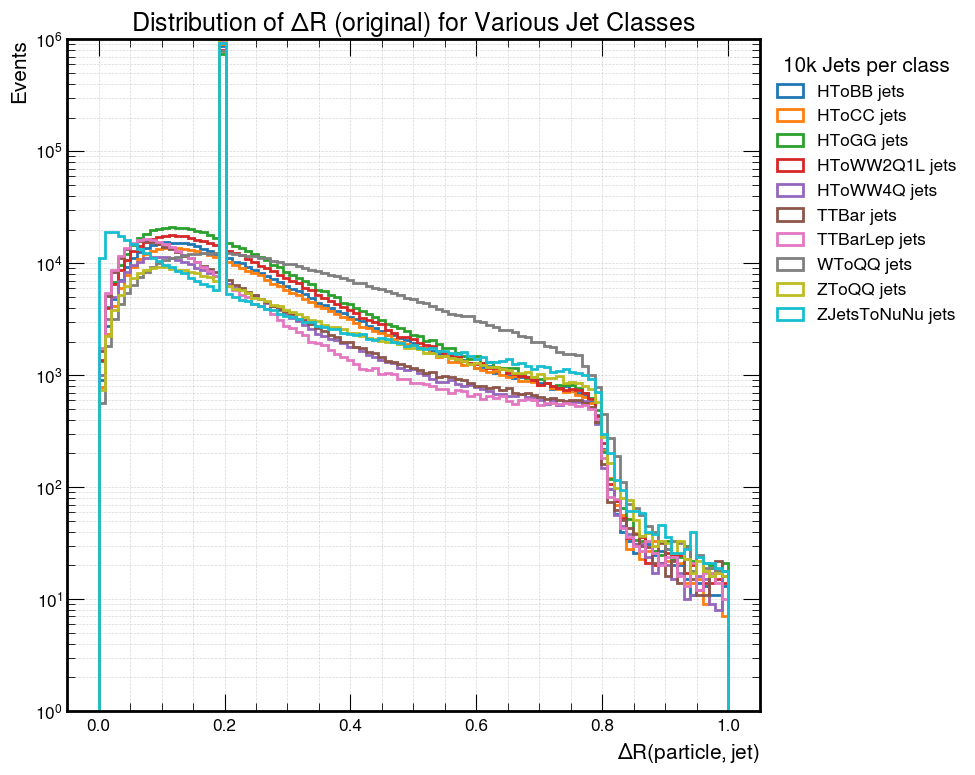

In [44]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_orig[label], bins=np.linspace(0,1,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of $\Delta R$ (original) for Various Jet Classes")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/deltaR_orig", bbox_inches='tight', dpi=300)
plt.show()


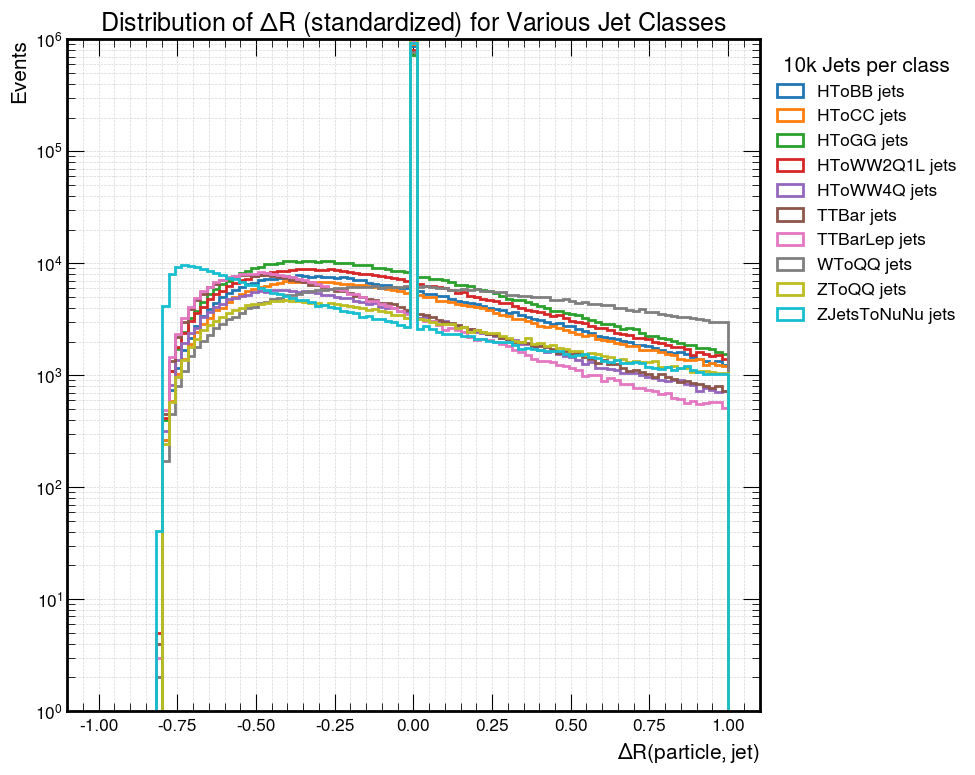

In [45]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_xformed[label], bins=np.linspace(-1,1,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of $\Delta R$ (standardized) for Various Jet Classes")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/deltaR_xformed", bbox_inches='tight', dpi=300)
plt.show()


## Augmented jets

In [46]:
# which feature to look at?
feature = "deltaR"
index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features_orig = {}
features_xformed = {}
for label in labels:
    features_orig[label] = []
    features_xformed[label] = []

for i in tqdm(range(len(some_labels))):
    label = some_labels[i]
    jet = augmented_jets[i]
    for particle in jet.T:
        xform = get_inv_xformation("deltaR")
        feat_xformed = particle[index].item()
        feat_orig = xform(feat_xformed)
        features_orig[label_dict[label.item()]].append(feat_orig)
        features_xformed[label_dict[label.item()]].append(feat_xformed)

feature deltaR corresponding to index 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:53<00:00, 577.06it/s]


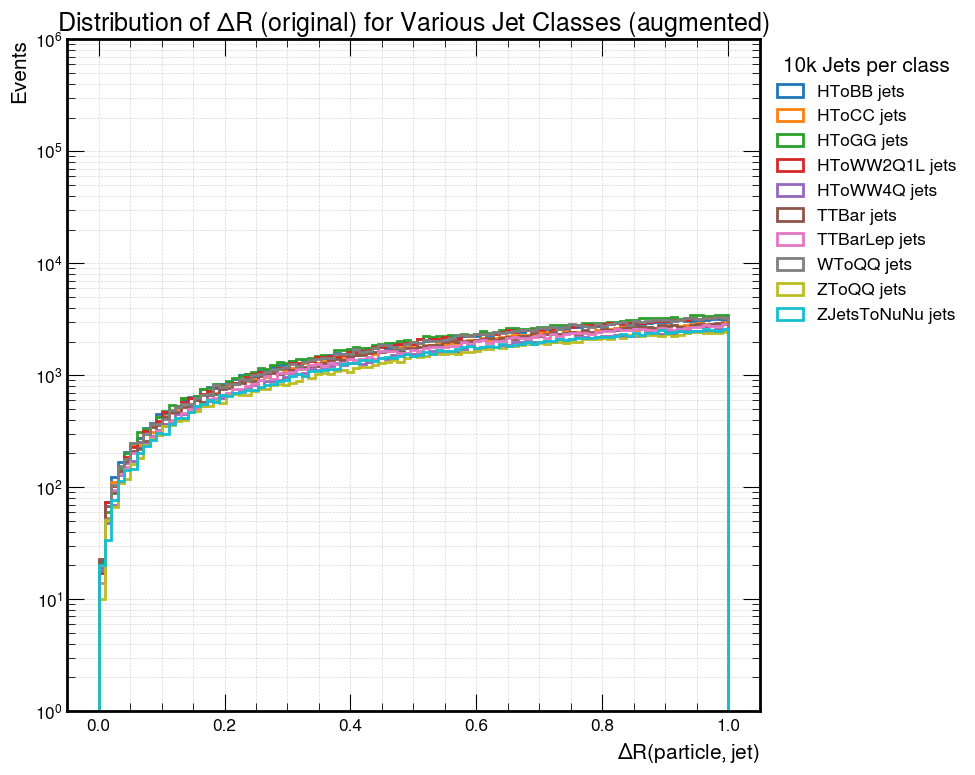

In [47]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_orig[label], bins=np.linspace(0,1,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of $\Delta R$ (original) for Various Jet Classes (augmented)")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/deltaR_augmented_orig", bbox_inches='tight', dpi=300)
plt.show()


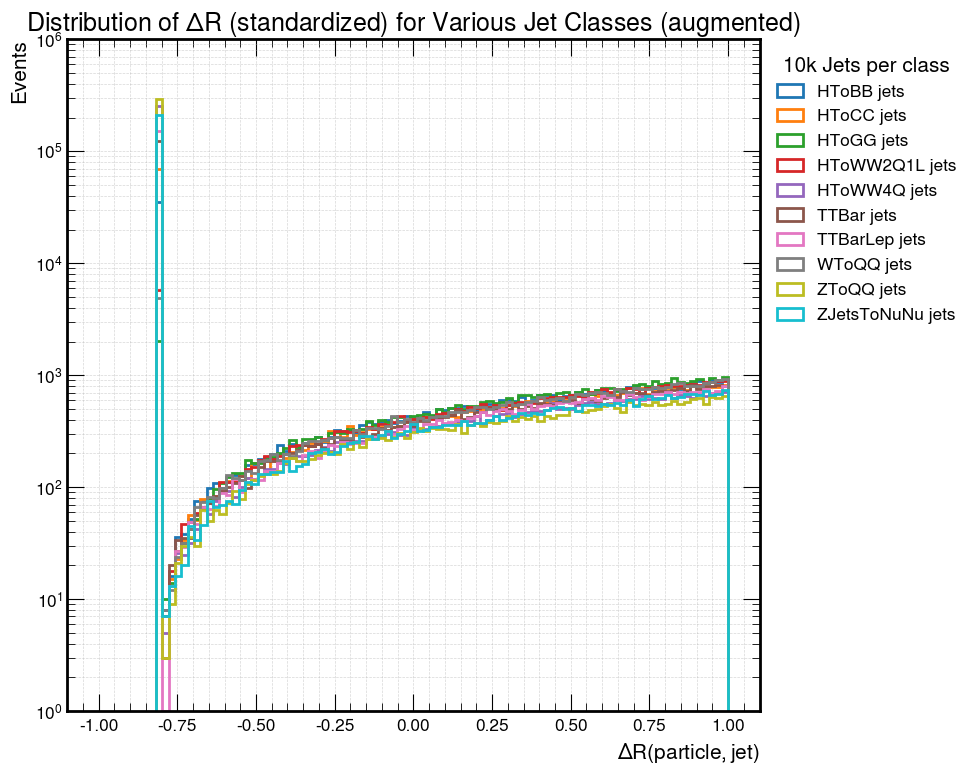

In [48]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_xformed[label], bins=np.linspace(-1,1,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of $\Delta R$ (standardized) for Various Jet Classes (augmented)")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/deltaR_augmented_xformed", bbox_inches='tight', dpi=300)
plt.show()


# $\eta$

In [52]:
# which feature to look at?
feature = "eta"
index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features_orig = {}
for label in labels:
    features_orig[label] = []

for i in tqdm(range(len(all_labels))):
    if i % 10 == 0:
        label = all_labels[i]
        jet = all_jets[i]
        for particle in jet.T:
            feat_orig = particle[index].item()
            features_orig[label_dict[label.item()]].append(np.abs(feat_orig))

feature eta corresponding to index 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:59<00:00, 16898.12it/s]


In [53]:
print(min(features_orig['HToBB']), max(features_orig['HToBB']))

0.0 3.060340166091919


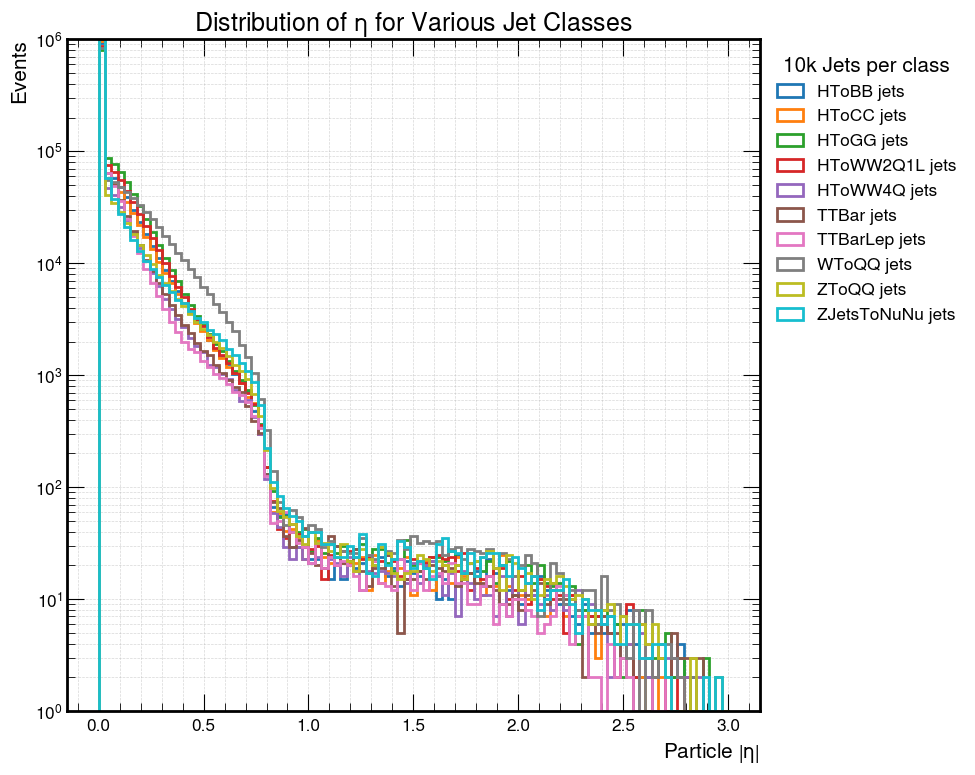

In [54]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_orig[label], bins=np.linspace(0,3,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of $\eta$ for Various Jet Classes")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/eta", bbox_inches='tight', dpi=300)
plt.show()


## Augmented jets

In [55]:
# which feature to look at?
feature = "eta"
index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features_orig = {}
for label in labels:
    features_orig[label] = []

for i in tqdm(range(len(some_labels))):
    label = some_labels[i]
    jet = augmented_jets[i]
    for particle in jet.T:
        feat_orig = particle[index].item()
        features_orig[label_dict[label.item()]].append(np.abs(feat_orig))

feature eta corresponding to index 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:09<00:00, 529.07it/s]


In [56]:
print(min(features_orig['HToBB']), max(features_orig['HToBB']))

0.0 10.647804260253906


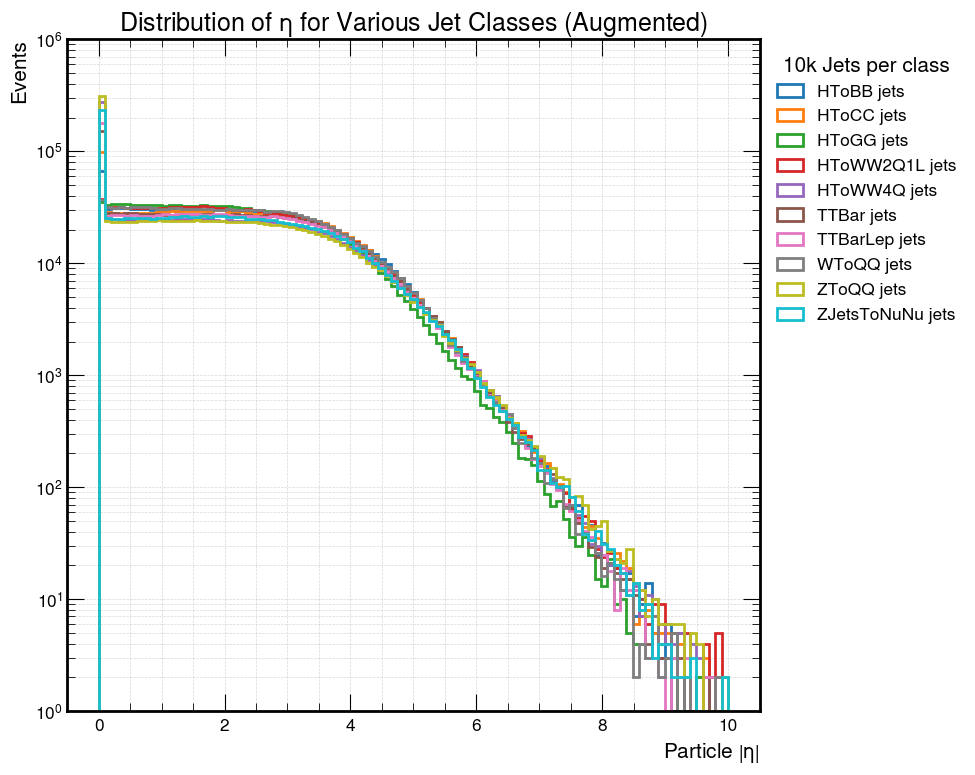

In [57]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_orig[label], bins=np.linspace(0,10,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of $\eta$ for Various Jet Classes (Augmented)")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/eta_augmented", bbox_inches='tight', dpi=300)
plt.show()


# $\phi$

In [58]:
# which feature to look at?
feature = "phi"
index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features_orig = {}
for label in labels:
    features_orig[label] = []

for i in tqdm(range(len(all_labels))):
    if i % 10 == 0:
        label = all_labels[i]
        jet = all_jets[i]
        for particle in jet.T:
            feat_orig = particle[index].item()
            features_orig[label_dict[label.item()]].append(np.abs(feat_orig))

feature phi corresponding to index 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:59<00:00, 16897.21it/s]


In [59]:
print(min(features_orig['HToBB']), max(features_orig['HToBB']))

0.0 1.0264668464660645


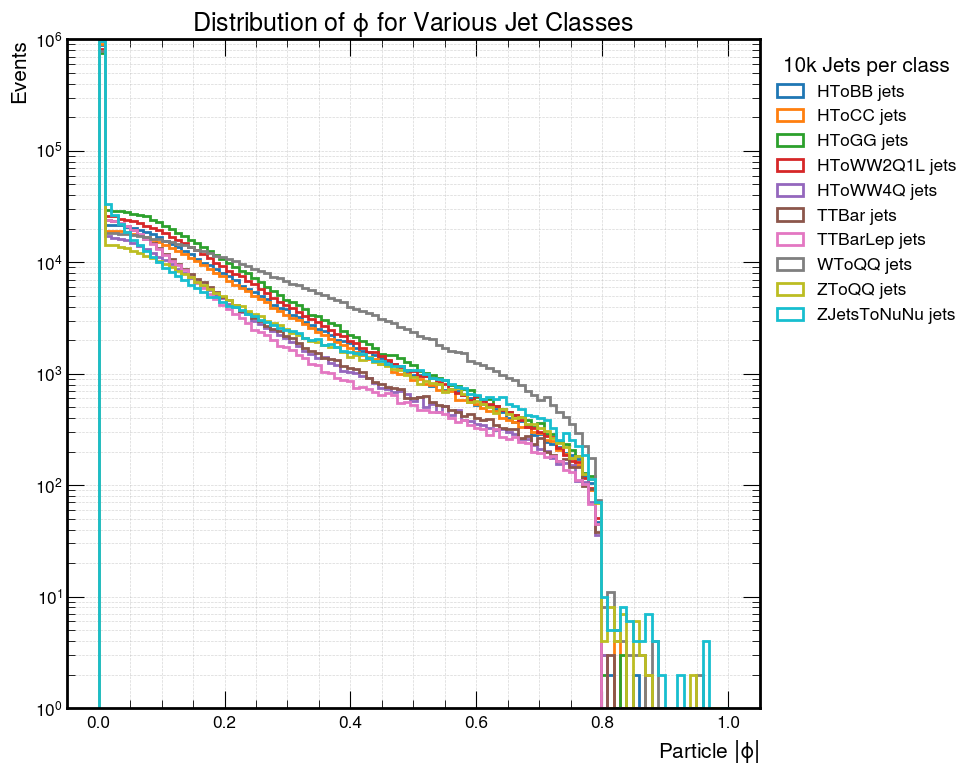

In [60]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_orig[label], bins=np.linspace(0,1,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of $\phi$ for Various Jet Classes")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/phi", bbox_inches='tight', dpi=300)
plt.show()


## Augmented jets

In [62]:
# which feature to look at?
feature = "phi"
index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features_orig = {}
for label in labels:
    features_orig[label] = []

for i in tqdm(range(len(some_labels))):
    label = some_labels[i]
    jet = augmented_jets[i]
    for particle in jet.T:
        feat_orig = particle[index].item()
        features_orig[label_dict[label.item()]].append(np.abs(feat_orig))

feature phi corresponding to index 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:07<00:00, 532.22it/s]


In [65]:
print(min(features_orig['HToBB']), max(features_orig['HToBB']))
print(min(features_orig['HToCC']), max(features_orig['HToCC']))

0.0 4.167680263519287
0.0 4.210080146789551


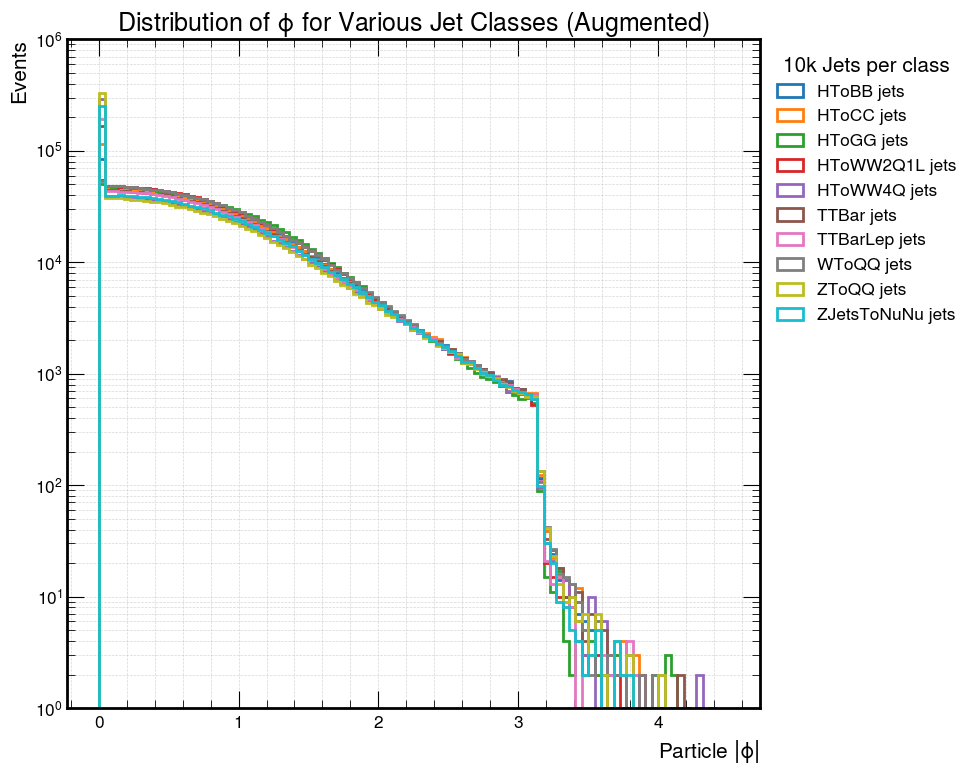

In [67]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_orig[label], bins=np.linspace(0,4.5,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of $\phi$ for Various Jet Classes (Augmented)")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/phi_augmented", bbox_inches='tight', dpi=300)
plt.show()


# log $pT$

In [69]:
# which feature to look at?
feature = "pt"
index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features_orig = {}
features_xformed = {}
for label in labels:
    features_orig[label] = []
    features_xformed[label] = []

for i in tqdm(range(len(all_labels))):
    if i % 10 == 0:
        label = all_labels[i]
        jet = all_jets[i]
        for particle in jet.T:
            xform = get_inv_xformation(feature)
            feat_xformed = particle[index].item()
            feat_orig = xform(feat_xformed)
            features_orig[label_dict[label.item()]].append(feat_orig)
            features_xformed[label_dict[label.item()]].append(feat_xformed)

feature pt corresponding to index 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:54<00:00, 18319.96it/s]


In [73]:
print(min(features_orig['HToBB']), max(features_orig['HToBB']))
print(min(features_orig['HToCC']), max(features_orig['HToCC']))

-2.206199591500419 6.492534623827254
-1.9710054533822199 6.37827320098877


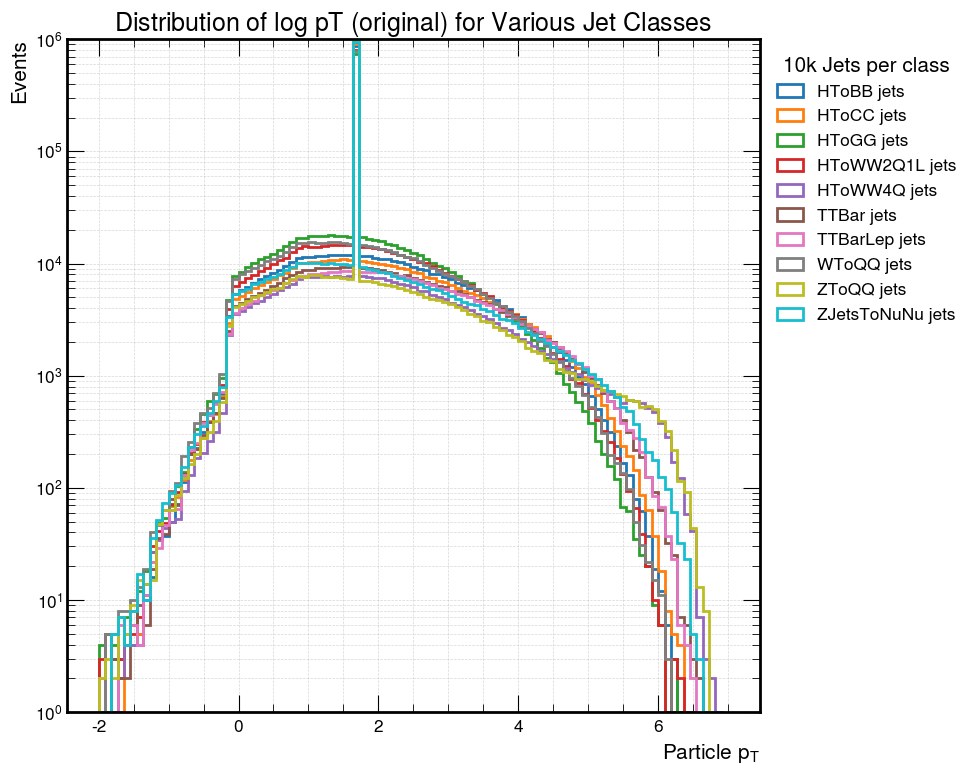

In [74]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_orig[label], bins=np.linspace(-2,7,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of log $pT$ (original) for Various Jet Classes")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/logpT_orig", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

fig, ax = plt.subplots(figsize=(10, 8))

for label in labels:
    plt.hist(features_xformed[label], bins=np.linspace(-2,7,100), histtype="step", linewidth=2, label=f"{label} jets")

# Set limits and scale
# ax.set_xlim(-1,2.5)
ax.set_yscale('log')
ax.set_ylim(1, 1e6)  # Adjust the upper limit according to your data

# Add grids
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

# Legend outside the plot
ax.legend(title="10k Jets per class", loc='upper left', bbox_to_anchor=(1, 1))

# Labels and Title
ax.set_xlabel(feature_label[feature])
ax.set_ylabel(r"Events")
ax.set_title("Distribution of log $\pT$ (standardized) for Various Jet Classes")

# Save and Show
plt.tight_layout()
plt.savefig(f"{save_path}/logpT_xformed", bbox_inches='tight', dpi=300)
plt.show()
